In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import shap
from shap.maskers import Independent
from shap.plots import colors
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from util import plot_decision_boundary, encode_one_hot, reduce_multiclass_proba_diff_shap_values
from helper_models import RuleClassifier
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
%matplotlib inline

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.75, random_state=2)
feature_names = np.array(['x1', 'x2'])
n_features = len(feature_names)
n_samples = X.shape[0]

In [3]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

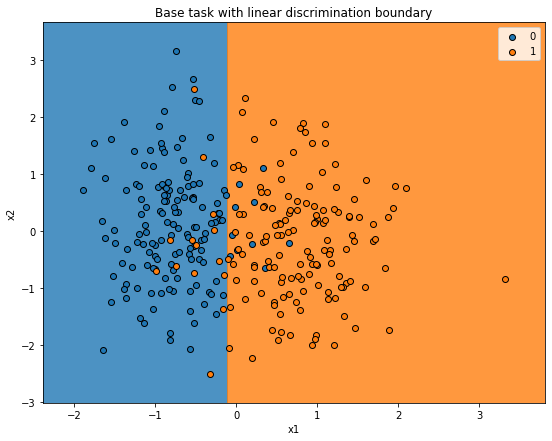

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_decision_boundary(tree.predict, data=X, z=y, class_names=tree.classes_,
                       title='Base task with linear discrimination boundary',
                       feature_names=feature_names, fig=fig, ax=ax)

In [5]:
idx_feature = tree.tree_.feature[0]
threshold = tree.tree_.threshold[0]
clf_a = RuleClassifier(lambda X: X[:, idx_feature] > threshold)
clf_a.fit(X, y)
clf_b = RuleClassifier(lambda X: X[:, idx_feature] > threshold + 0.1)
clf_b.fit(X, y)

RuleClassifier(decision_rule=<function <lambda> at 0x12cd34310>)

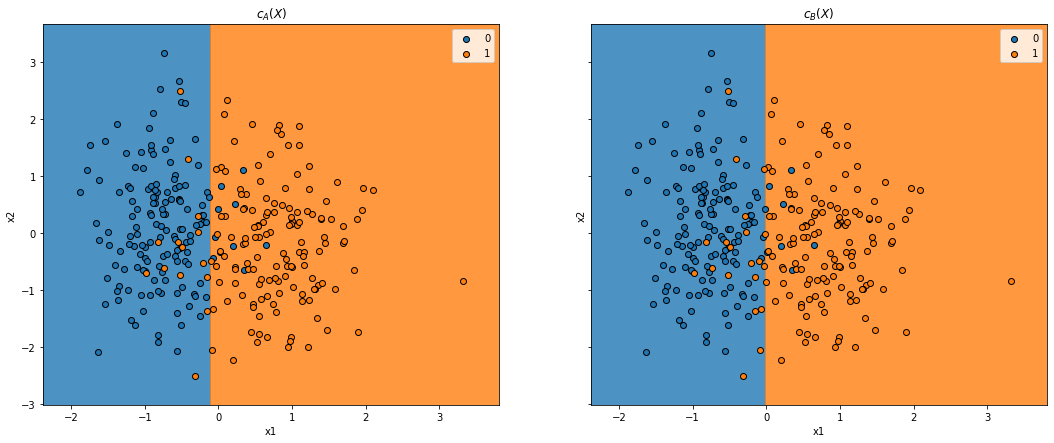

In [6]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(2 * 9, 7))
plot_decision_boundary(clf_a.predict, data=X, z=y, class_names=clf_a.classes_,
                       title='$c_A(X)$', feature_names=feature_names, fig=fig, ax=axs[0])
plot_decision_boundary(clf_b.predict, data=X, z=y, class_names=clf_b.classes_,
                       title='$c_B(X)$', feature_names=feature_names, fig=fig, ax=axs[1])

In [7]:
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
binary_label_diff = binary_diff_clf.predict(X)

In [8]:
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
label_diff = diff_clf.predict(X)

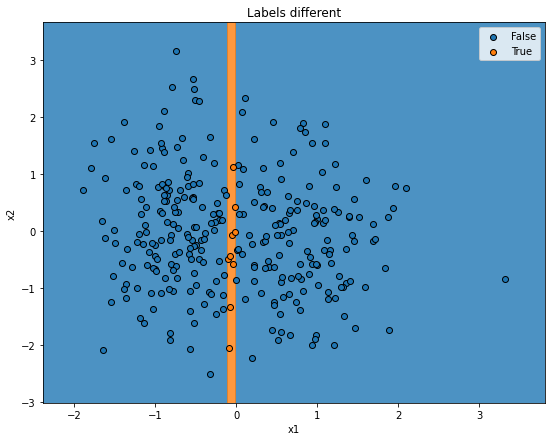

In [9]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_decision_boundary(binary_diff_clf.predict, data=X, z=binary_label_diff, class_names=binary_diff_clf.classes_,
                       title='Labels different', feature_names=feature_names, fig=fig, ax=ax)

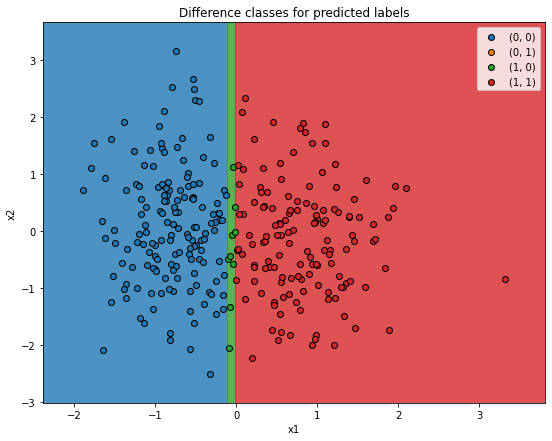

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_decision_boundary(diff_clf.predict, data=X,z=label_diff, class_names=diff_clf.class_tuples_,
                       title='Difference classes for predicted labels', feature_names=feature_names, fig=fig, ax=ax)

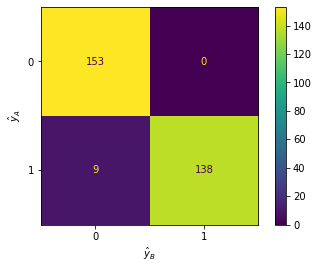

In [12]:
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
cm = confusion_matrix(pred_a, pred_b, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
fig, ax = plt.subplots()
disp.plot(ax=ax)
ax.set_ylabel('$\hat{y}_A$')
ax.set_xlabel('$\hat{y}_B$')
plt.show()

In [13]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=background_data.shape[0])
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(clf_a.predict)
shap_values_b = explain(clf_b.predict)

CPU times: user 3.74 s, sys: 69.1 ms, total: 3.81 s
Wall time: 3.91 s


In [14]:
shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data

In [15]:
%%time
n_diff_classes = len(diff_clf.classes_)
shap_values_diff = explain(lambda X: encode_one_hot(diff_clf.predict(X), n_diff_classes))

CPU times: user 2.07 s, sys: 19.1 ms, total: 2.09 s
Wall time: 2.11 s


In [16]:
binary_diff_shap_values = reduce_multiclass_proba_diff_shap_values(shap_values_diff)
feature_importance = binary_diff_shap_values.abs.mean(axis=0)
feature_order = np.flip(feature_importance.values.argsort())

In [17]:
indices = np.indices(y.shape).ravel()
is_pred_diff = binary_diff_clf.predict(X)
is_pred_equal = ~is_pred_diff

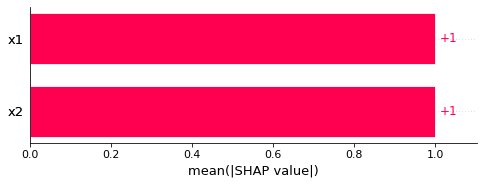

In [18]:
shap.plots.bar(feature_importance, max_display=n_features)

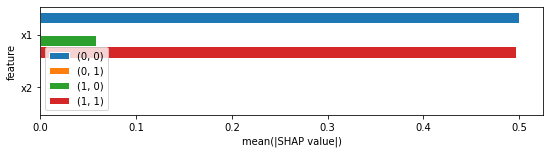

In [20]:
bar_width = 0.22
importances = shap_values_diff.abs.mean(0).values.T
rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
fig, ax = plt.subplots(figsize=(9, n_features))
for class_idx, rect, importance in zip(diff_clf.classes_, rects, importances):
    ax.barh(rect, importance, height=bar_width, edgecolor='white', label=str(diff_clf.class_tuples_[class_idx]))
ax.set_ylabel('feature')
ax.set_xlabel('mean(|SHAP value|)')
ax.set_yticks([r + bar_width * (len(diff_clf.classes_) - 1)/2 for r in range(importances.shape[1])])
ax.set_yticklabels(feature_names)
ax.invert_yaxis()
ax.legend()
plt.show()

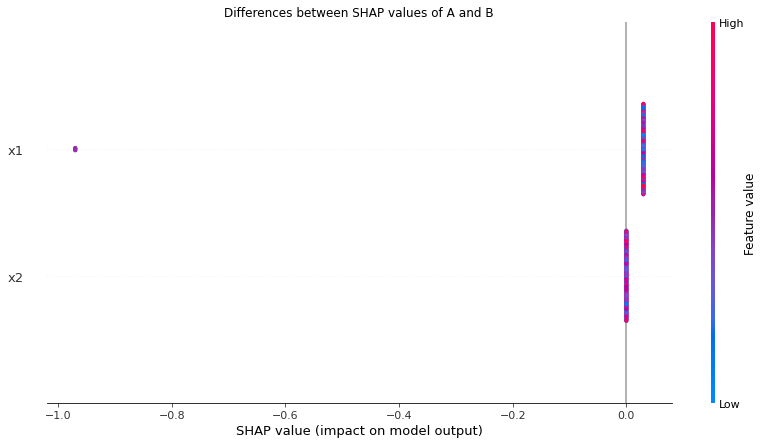

In [21]:
plt.title('Differences between SHAP values of A and B')
shap.plots.beeswarm(shap_values_a_vs_b, order=feature_order, plot_size=(14, 7))

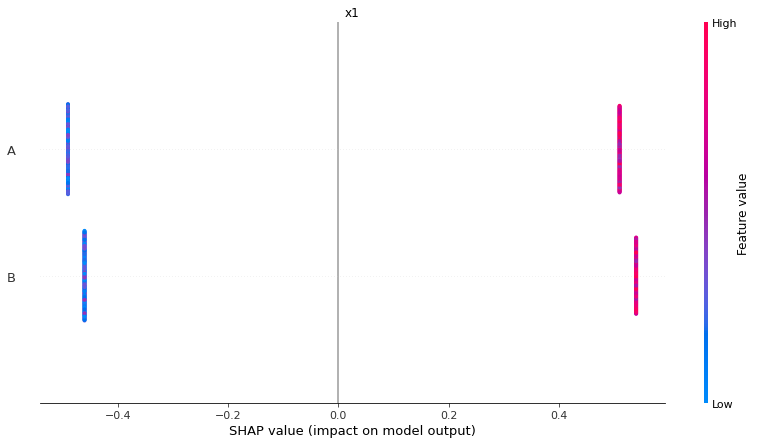

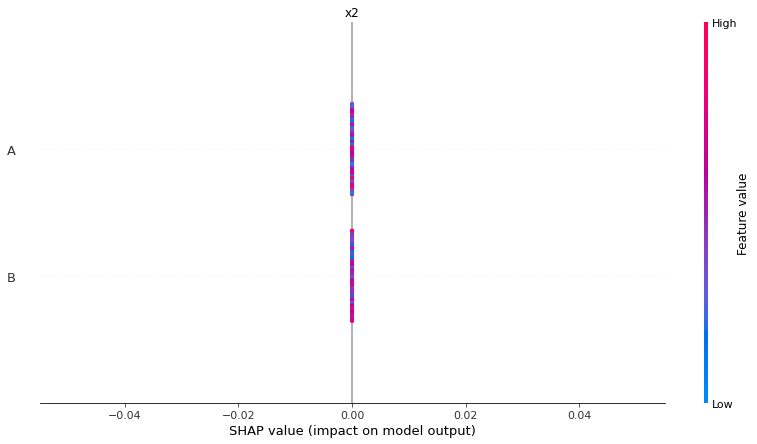

In [22]:
for feature_idx in feature_order:
    new_values = np.array([s.values[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    new_data = np.array([s.data[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    if shap_values_a.display_data is not None:
        new_display_data = np.array([s.display_data[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    else:
        new_display_data = None
    new_base_values = np.array([s.base_values for s in (shap_values_a, shap_values_b)]).T
    shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=['A', 'B'])
    shap.plots.beeswarm(shap_values_, plot_size=(14, 7), order=[0, 1], show=False)
    plt.title(feature_names[feature_idx])
    plt.show()

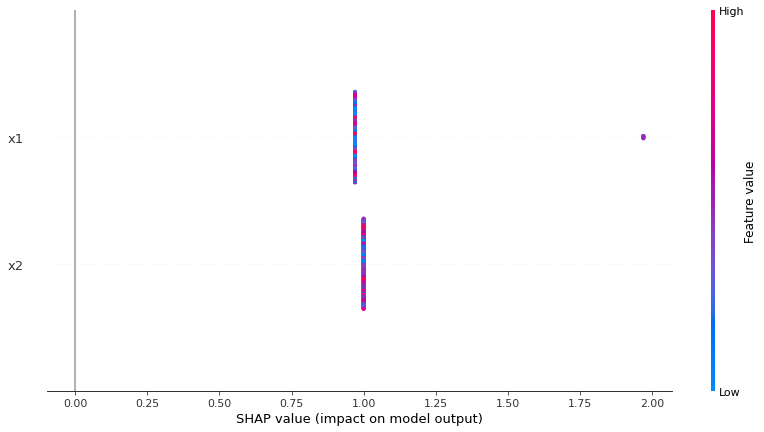

In [23]:
shap.plots.beeswarm(binary_diff_shap_values, order=feature_order, plot_size=(14, 7))

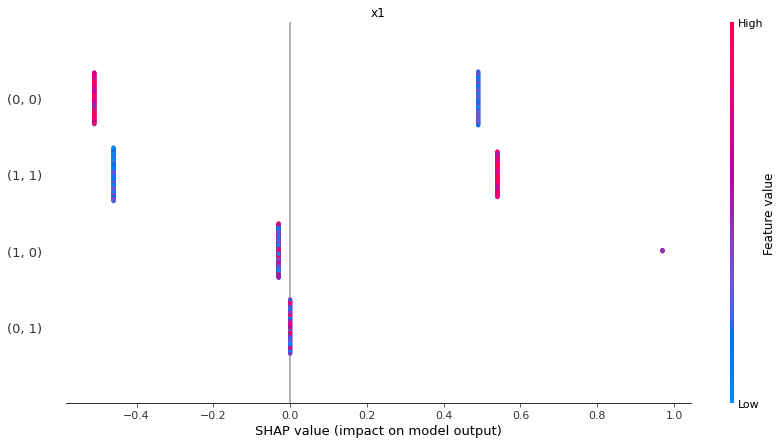

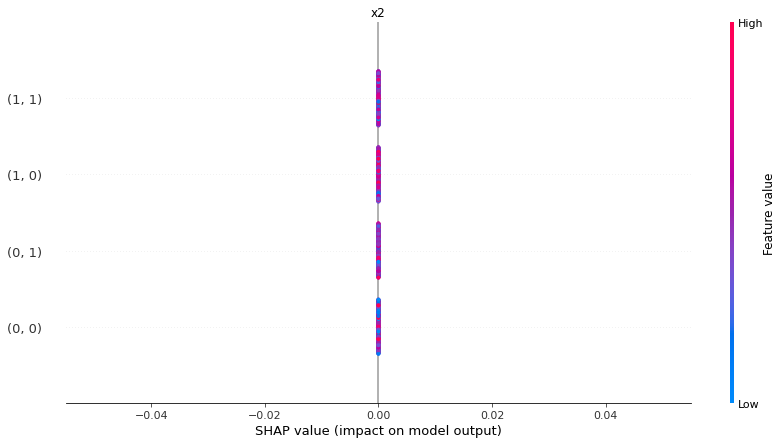

In [25]:
for feature_idx in feature_order:
    new_values = shap_values_diff.values[:, feature_idx, :]
    new_data = np.reshape(np.repeat(shap_values_diff.data[:, feature_idx], len(diff_clf.classes_)), (X.shape[0], len(diff_clf.classes_)))
    if shap_values_diff.display_data is not None:
        new_display_data = np.reshape(np.repeat(shap_values_diff.display_data[:, feature_idx], len(diff_clf.classes_)), (X.shape[0], len(diff_clf.classes_)))
    else:
        new_display_data = None
    new_base_values = shap_values_diff.base_values
    class_names = [str(class_tuple) for class_tuple in diff_clf.class_tuples_]
    shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=class_names)
    shap.plots.beeswarm(shap_values_, plot_size=(14, 7), show=False)
    plt.title(feature_names[feature_idx])
    plt.show()

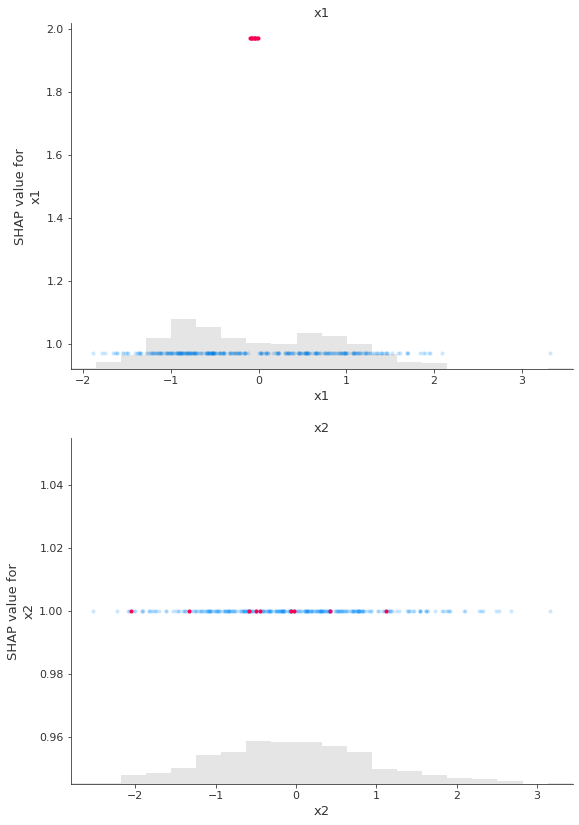

In [26]:
n_columns = 1
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    shap.plots.scatter(binary_diff_shap_values[:, feature],
                       ax=ax,
                       color=tuple(colors.blue_rgb),
                       alpha=0.2,
                       show=False)
    shap.plots.scatter(binary_diff_shap_values[is_pred_diff, feature],
                       title=feature,
                       ax=ax,
                       color=tuple(colors.red_rgb),
                       hist=False,
                       show=False)
    i += n_columns
plt.show()

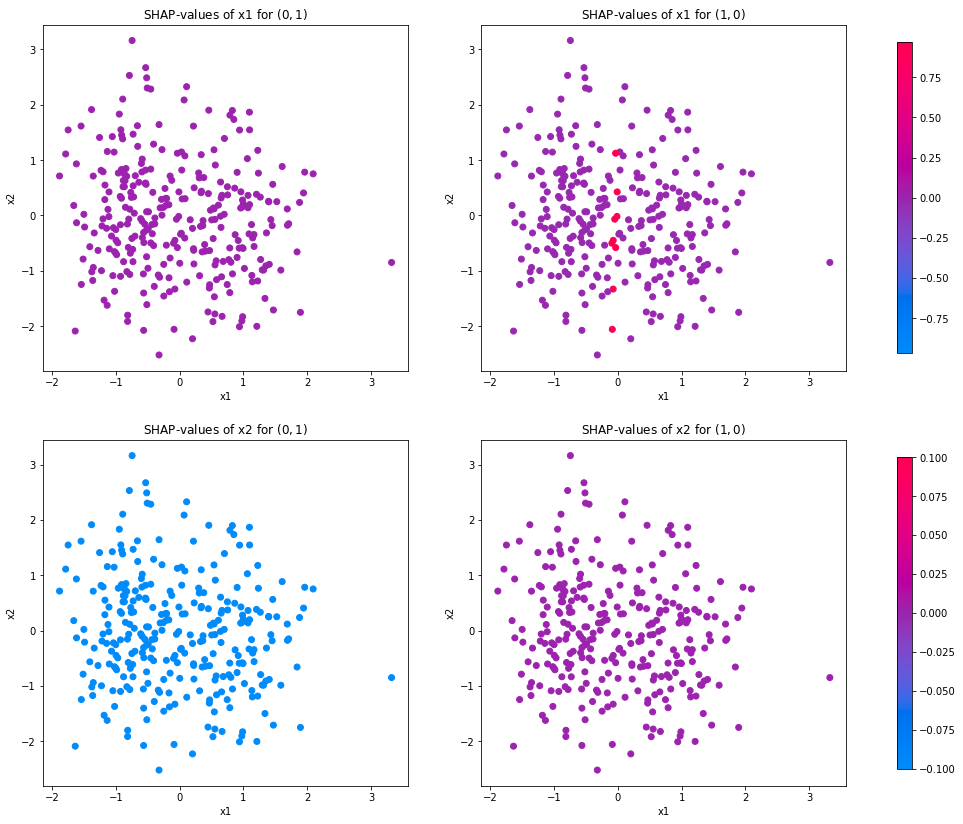

In [30]:
n_columns = len(diff_clf.difference_classes_)
n_rows = n_features
fig, axs = plt.subplots(n_rows, n_columns, figsize=(9*n_columns, 7*n_rows))
plot_idx = 0
for feature_idx in range(n_features):
    vmax = np.max(np.abs(shap_values_diff.values[:, feature_idx, diff_clf.difference_classes_]))
    for class_idx in diff_clf.difference_classes_:
        class_tuple = diff_clf.class_tuples_[class_idx]
        ax = axs.flat[plot_idx]
        cs = ax.scatter(X[:, 0],
                        X[:, 1],
                        c=shap_values_diff.values[:, feature_idx, class_idx],
                        vmin=-vmax, vmax=vmax,
                        cmap=colors.red_blue,
                        alpha=1)
        ax.set_title(f'SHAP-values of {feature_names[feature_idx]} for ${class_tuple}$')
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
        plot_idx += 1
    fig.colorbar(cs, ax=axs[feature_idx].tolist(), shrink=0.9)
plt.show()